# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# **Load & Preview**

In [7]:
df = pd.read_csv('Reviews.csv')
df = df[['Score', 'Text', 'Summary', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']]

In [8]:
df.head()

,Score,Text,Summary,HelpfulnessNumerator,HelpfulnessDenominator,Time
0,5,I have bought several of the Vitality canned d...,Good Quality Dog Food,1,1,1303862400
1,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,0,0,1346976000
2,4,This is a confection that has been around a fe...,"""Delight"" says it all",1,1,1219017600
3,2,If you are looking for the secret ingredient i...,Cough Medicine,3,3,1307923200
4,5,Great taffy at a great price. There was a wid...,Great taffy,0,0,1350777600


In [9]:
df.isnull().sum()

,0
Score,0
Text,0
Summary,27
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Time,0


In [11]:
df['Summary'] = df['Summary'].fillna('No summary provided')


In [12]:
df.dtypes

,0
Score,int64
Text,object
Summary,object
HelpfulnessNumerator,int64
HelpfulnessDenominator,int64
Time,int64


In [13]:
# conversion of object types to string
df['Text'] = df['Text'].astype(str)
df['Summary'] = df['Summary'].astype(str)

# **EDA**

<Axes: xlabel='helpfulness_ratio', ylabel='Count'>

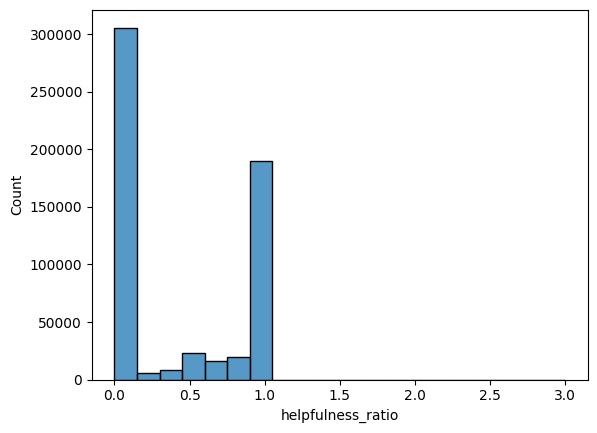

In [15]:
# helpfullness ratio
df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)
sns.histplot(df['helpfulness_ratio'].dropna(), bins=20)

<Axes: xlabel='word_count', ylabel='Count'>

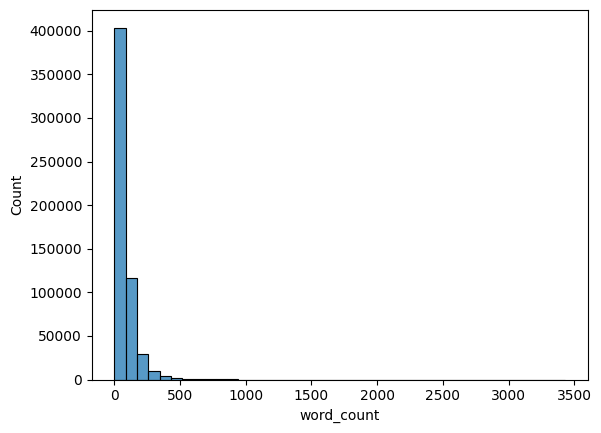

In [16]:
# word count
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['word_count'], bins=40)

/tmp/ipython-input-17-1884931839.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M').size().plot(kind='bar')


<Axes: xlabel='Time'>

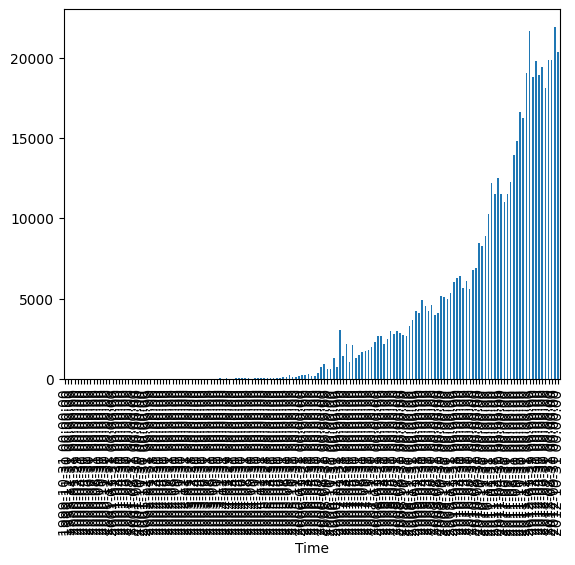

In [17]:
# review volume over time
df['Time'] = pd.to_datetime(df['Time'], unit='s')
df.set_index('Time', inplace=True)
df.resample('M').size().plot(kind='bar')

# **Sentiment Labels from 'Score' column**

In [19]:
def get_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score <= 2:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Score'].apply(get_sentiment)
df = df[df['Sentiment'] != 'Neutral']  # binary classification


# **Clean Text**
*   Lowercase
*   remove punctuation
*   stopwords

In [20]:
import re, string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-20-1571905706.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['Text'].apply(clean_text)


# **Visualizing reviews**

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

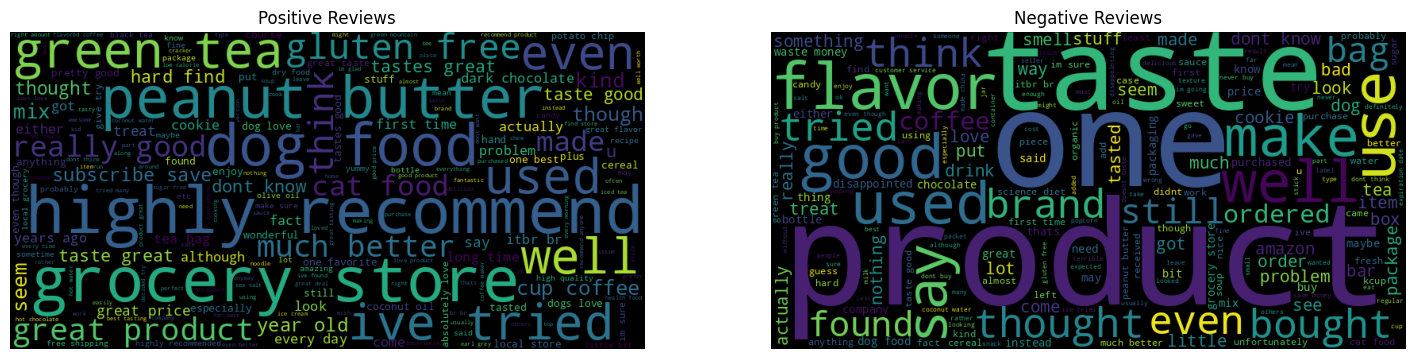

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text = " ".join(df[df['Sentiment'] == 'Positive']['clean_text'])
negative_text = " ".join(df[df['Sentiment'] == 'Negative']['clean_text'])

fig, axs = plt.subplots(1, 2, figsize=(18, 7))
axs[0].imshow(WordCloud(width=800, height=400).generate(positive_text))
axs[0].set_title("Positive Reviews")
axs[0].axis("off")

axs[1].imshow(WordCloud(width=800, height=400).generate(negative_text))
axs[1].set_title("Negative Reviews")
axs[1].axis("off")


In [25]:
import os
if not os.path.exists('wordclouds'):
    os.makedirs('wordclouds')

plt.savefig('wordclouds/positive_vs_negative.png')

<Figure size 640x480 with 0 Axes>

# **Vectorization**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['clean_text'])
y = df['Sentiment']

# **Regression Model**

              precision    recall  f1-score   support

    Negative       0.83      0.67      0.74     16379
    Positive       0.94      0.98      0.96     88784

    accuracy                           0.93    105163
   macro avg       0.89      0.82      0.85    105163
weighted avg       0.92      0.93      0.92    105163



<Axes: >

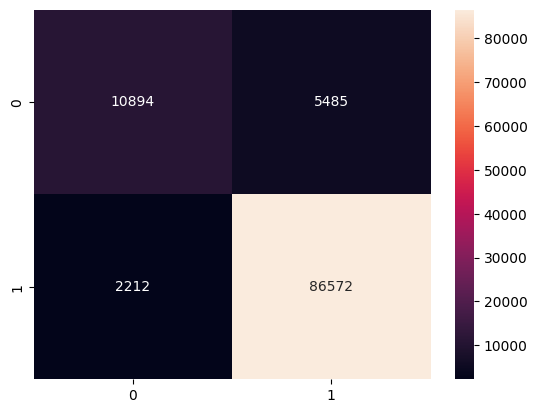

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')


In [26]:
import matplotlib.pyplot as plt
if not os.path.exists('confusion_matrices'):
    os.makedirs('confusion_matrices')

plt.savefig('confusion_matrices/sentiment_confusion_matrix.png')

<Figure size 640x480 with 0 Axes>